In [1]:
import os
import math
import pandas as pd
import shap
import numpy as np
from matplotlib import pyplot as plt

from imblearn.over_sampling import BorderlineSMOTE
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

import warnings
warnings.filterwarnings("ignore")


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Defining some useful variables

# Set the project folder
PRJ_FOLDER = '.'
# Set the folder the full dataset is located
DATA_FOLDER = os.path.join(PRJ_FOLDER, 'data')
# Set the name of the file that holds the full dataset
FULL_DATASET_NAME = 'full.csv'
# Set "No Audio" dataset
NO_AUDIO_DATASET_NAME = 'no_audio.csv'
# Set the name of the file that holds the angraphic information
LABELS_NAME = 'labels.csv'

TOP_K = 16

# Load the labels only once, in order to reuse them
LABELS = pd.read_csv(os.path.join(DATA_FOLDER, LABELS_NAME))

# SMOTE Upsampler
SMOTE = BorderlineSMOTE()


print(f'Folder where the entire project is located: {PRJ_FOLDER}')
print(f'Folder where the full dataset is saved: {DATA_FOLDER}')
print(f'Name of the full dataset: {FULL_DATASET_NAME}')
print(f'Name of the anagraphic dataset: {LABELS_NAME}')

Folder where the entire project is located: .
Folder where the full dataset is saved: .\data
Name of the full dataset: full.csv
Name of the anagraphic dataset: labels.csv


In [3]:
# Let's define a simple function that loads a single dataset

def load_raw_data(csv_path: str, feat_to_predict: str):
    # Load the entire csv file
    data = pd.read_csv(csv_path)

    # Join labels and data so that truth values are aligned with original data
    lbls = LABELS[['id', feat_to_predict]]
    temp = data.merge(lbls, on='id', how='left')
    temp = temp.dropna()
    # Extract only the ground truths
    labels = pd.DataFrame(temp[feat_to_predict], columns=[feat_to_predict])
    data = temp.drop(feat_to_predict, axis=1)
    data = data.set_index('id')
    data = pd.DataFrame(StandardScaler().fit_transform(data), columns=data.columns, index=data.index)

    #return data.to_numpy(), labels.to_numpy().reshape((len(labels), ))
    return data, labels

In [4]:
def plot_best_feat(feats, scores, yerr=None, title: str = '', dimensions=(10,8)):
    plt.rcParams["figure.figsize"] = dimensions

    feats, scores = list(reversed(feats)), list(reversed(scores))

    if yerr:
        plt.barh(feats, scores, yerr=yerr, capsize=6)
    else:
        plt.barh(feats, scores)
    plt.title(title)
    plt.xlabel('Score')
    plt.show()
    print(feats)

In [5]:
def plot_compounded(folds, title, dimensions=(10, 12)):
    plt.rcParams["figure.figsize"] = dimensions
    
    count = {}
    for feats, _ in folds:
        for feat in feats:
            if feat not in count:
                count[feat] = 0
            count[feat] += 1
    comp = sorted(list(count.items()), key=(lambda x: x[1]), reverse=True)
    feats, freqs = zip(*comp[:30])
    feats, freqs = list(reversed(list(feats))), list(reversed(list(freqs)))
    
    plt.barh(feats, freqs)
    plt.title(title)
    plt.xlabel('Frequency')
    plt.show()
    print(feats)
    print()

# ML Approach

In [170]:
def ml_analysis(feat_to_predict, audio=True):
    PATH = os.path.join(DATA_FOLDER, FULL_DATASET_NAME if audio else NO_AUDIO_DATASET_NAME)

    X, y = load_raw_data(PATH, feat_to_predict)
    results = []
    for _ in range(100):
        X_train, __, y_train, __ = train_test_split(X, y, test_size=0.2, stratify=y)
        X_train, y_train = SMOTE.fit_resample(X_train, y_train)
        
        sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
        sel.fit(X_train, y_train)

        support = sel.get_support()
        selected_feat = X.columns[support].tolist()
        selected_importances = sel.estimator_.feature_importances_.ravel()
        
        final_sorted = sorted(list(zip(selected_feat, selected_importances)), key=(lambda x: x[1]), reverse=True)
        feats, importances = zip(*(final_sorted[:TOP_K]))
        results.append((feats, importances))

    plot_compounded(results, feat_to_predict)


### Full Data

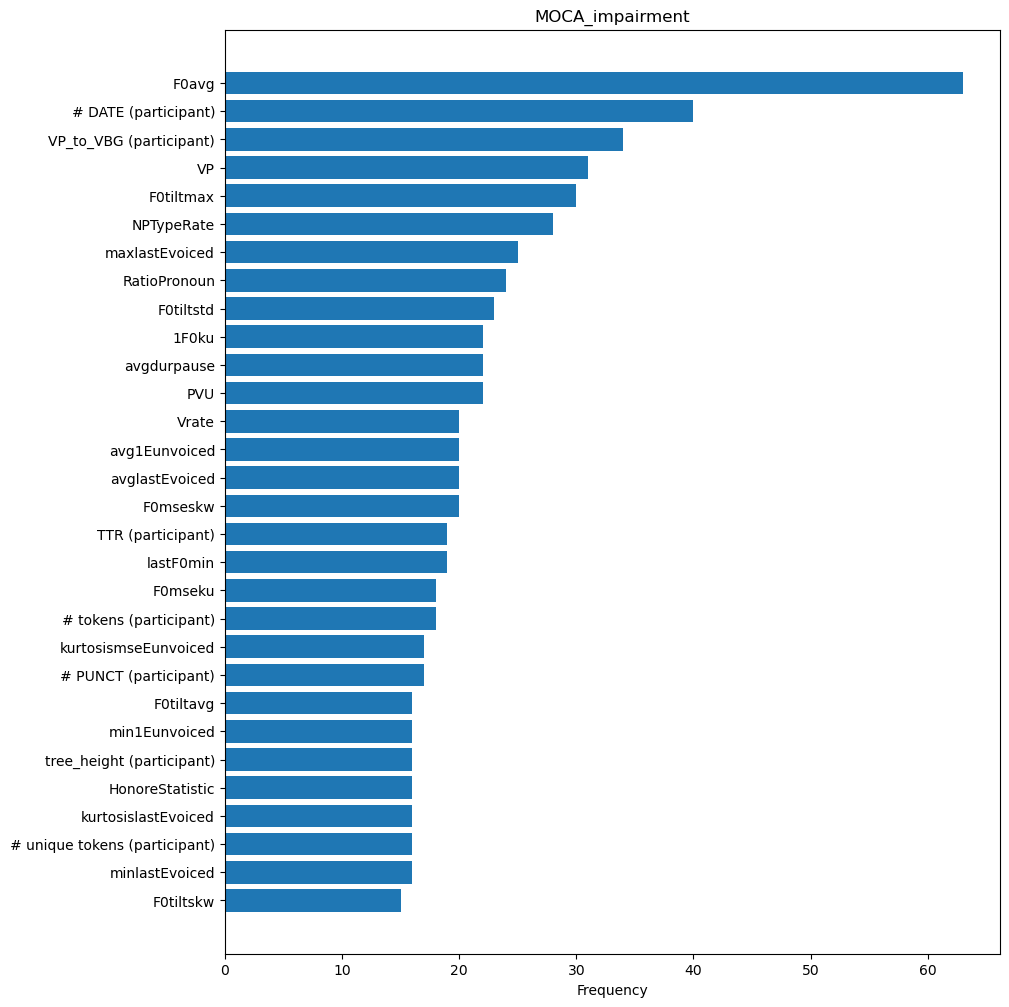

['F0tiltskw', 'minlastEvoiced', '# unique tokens (participant)', 'kurtosislastEvoiced', 'HonoreStatistic', 'tree_height (participant)', 'min1Eunvoiced', 'F0tiltavg', '# PUNCT (participant)', 'kurtosismseEunvoiced', '# tokens (participant)', 'F0mseku', 'lastF0min', 'TTR (participant)', 'F0mseskw', 'avglastEvoiced', 'avg1Eunvoiced', 'Vrate', 'PVU', 'avgdurpause', '1F0ku', 'F0tiltstd', 'RatioPronoun', 'maxlastEvoiced', 'NPTypeRate', 'F0tiltmax', 'VP', 'VP_to_VBG (participant)', '# DATE (participant)', 'F0avg']



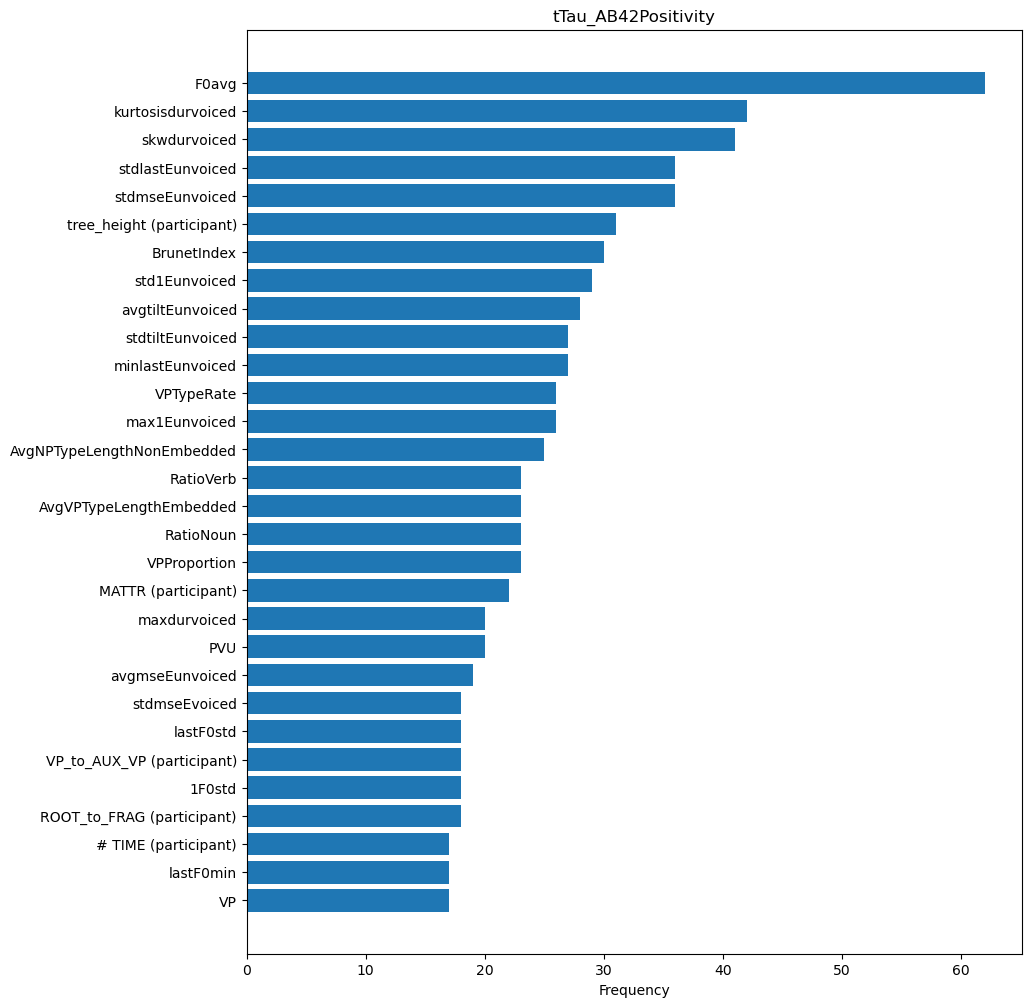

['VP', 'lastF0min', '# TIME (participant)', 'ROOT_to_FRAG (participant)', '1F0std', 'VP_to_AUX_VP (participant)', 'lastF0std', 'stdmseEvoiced', 'avgmseEunvoiced', 'PVU', 'maxdurvoiced', 'MATTR (participant)', 'VPProportion', 'RatioNoun', 'AvgVPTypeLengthEmbedded', 'RatioVerb', 'AvgNPTypeLengthNonEmbedded', 'max1Eunvoiced', 'VPTypeRate', 'minlastEunvoiced', 'stdtiltEunvoiced', 'avgtiltEunvoiced', 'std1Eunvoiced', 'BrunetIndex', 'tree_height (participant)', 'stdmseEunvoiced', 'stdlastEunvoiced', 'skwdurvoiced', 'kurtosisdurvoiced', 'F0avg']



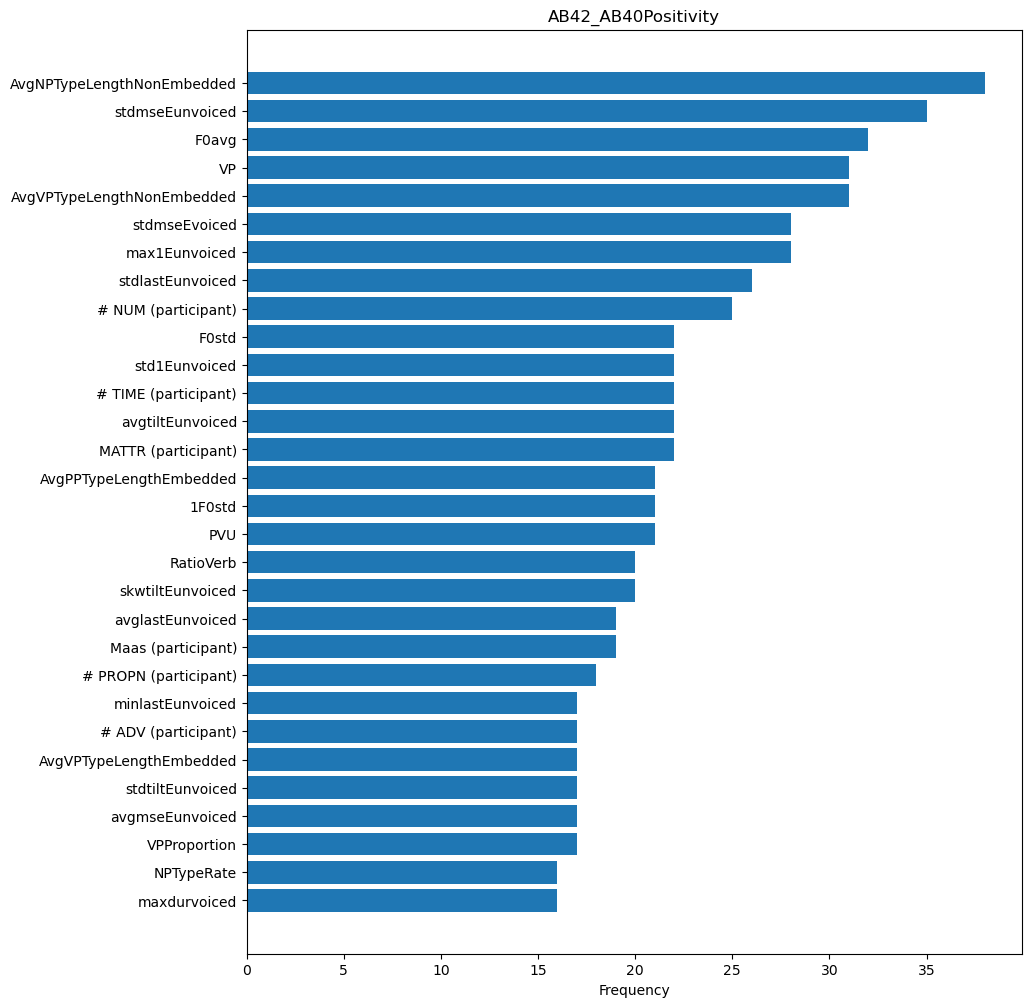

['maxdurvoiced', 'NPTypeRate', 'VPProportion', 'avgmseEunvoiced', 'stdtiltEunvoiced', 'AvgVPTypeLengthEmbedded', '# ADV (participant)', 'minlastEunvoiced', '# PROPN (participant)', 'Maas (participant)', 'avglastEunvoiced', 'skwtiltEunvoiced', 'RatioVerb', 'PVU', '1F0std', 'AvgPPTypeLengthEmbedded', 'MATTR (participant)', 'avgtiltEunvoiced', '# TIME (participant)', 'std1Eunvoiced', 'F0std', '# NUM (participant)', 'stdlastEunvoiced', 'max1Eunvoiced', 'stdmseEvoiced', 'AvgVPTypeLengthNonEmbedded', 'VP', 'F0avg', 'stdmseEunvoiced', 'AvgNPTypeLengthNonEmbedded']



In [207]:
ml_analysis('MOCA_impairment')
ml_analysis('tTau_AB42Positivity')
ml_analysis('AB42_AB40Positivity')

### No Audio

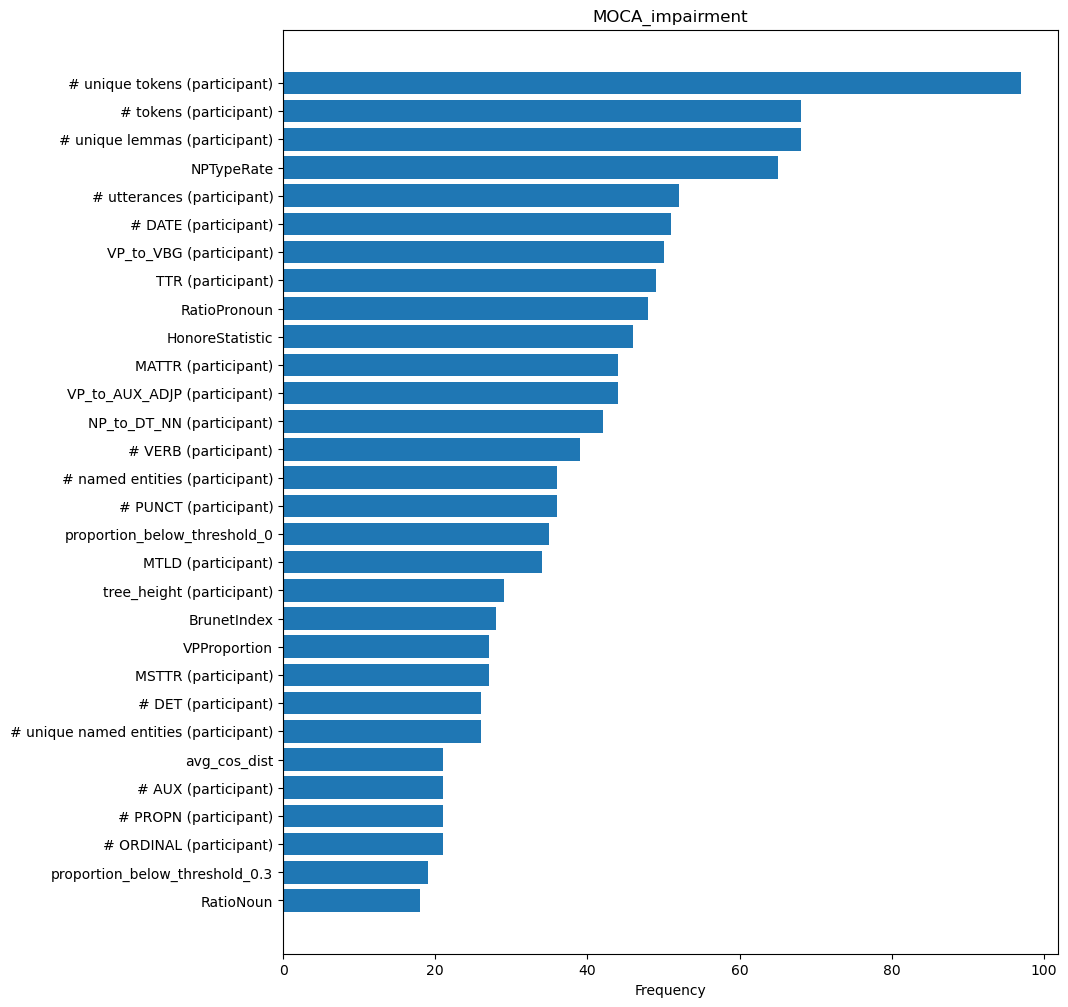

['RatioNoun', 'proportion_below_threshold_0.3', '# ORDINAL (participant)', '# PROPN (participant)', '# AUX (participant)', 'avg_cos_dist', '# unique named entities (participant)', '# DET (participant)', 'MSTTR (participant)', 'VPProportion', 'BrunetIndex', 'tree_height (participant)', 'MTLD (participant)', 'proportion_below_threshold_0', '# PUNCT (participant)', '# named entities (participant)', '# VERB (participant)', 'NP_to_DT_NN (participant)', 'VP_to_AUX_ADJP (participant)', 'MATTR (participant)', 'HonoreStatistic', 'RatioPronoun', 'TTR (participant)', 'VP_to_VBG (participant)', '# DATE (participant)', '# utterances (participant)', 'NPTypeRate', '# unique lemmas (participant)', '# tokens (participant)', '# unique tokens (participant)']



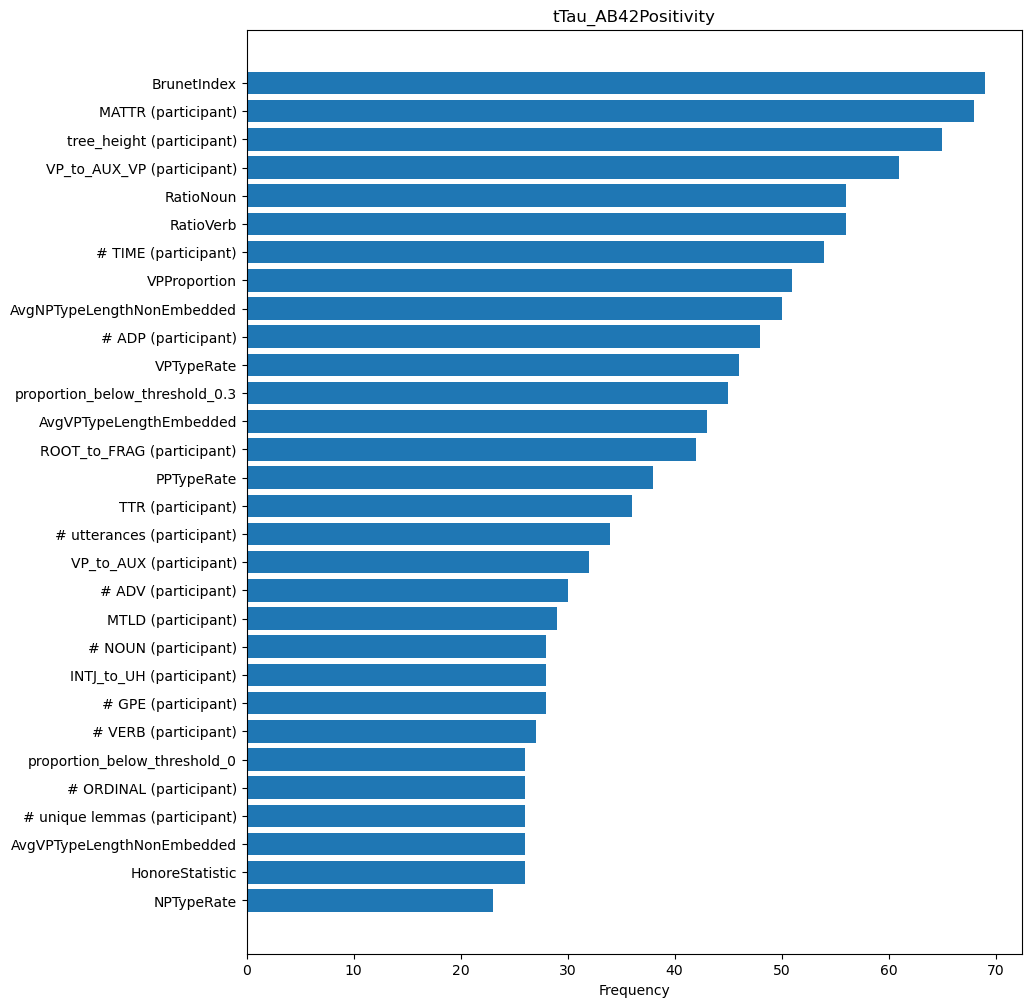

['NPTypeRate', 'HonoreStatistic', 'AvgVPTypeLengthNonEmbedded', '# unique lemmas (participant)', '# ORDINAL (participant)', 'proportion_below_threshold_0', '# VERB (participant)', '# GPE (participant)', 'INTJ_to_UH (participant)', '# NOUN (participant)', 'MTLD (participant)', '# ADV (participant)', 'VP_to_AUX (participant)', '# utterances (participant)', 'TTR (participant)', 'PPTypeRate', 'ROOT_to_FRAG (participant)', 'AvgVPTypeLengthEmbedded', 'proportion_below_threshold_0.3', 'VPTypeRate', '# ADP (participant)', 'AvgNPTypeLengthNonEmbedded', 'VPProportion', '# TIME (participant)', 'RatioVerb', 'RatioNoun', 'VP_to_AUX_VP (participant)', 'tree_height (participant)', 'MATTR (participant)', 'BrunetIndex']



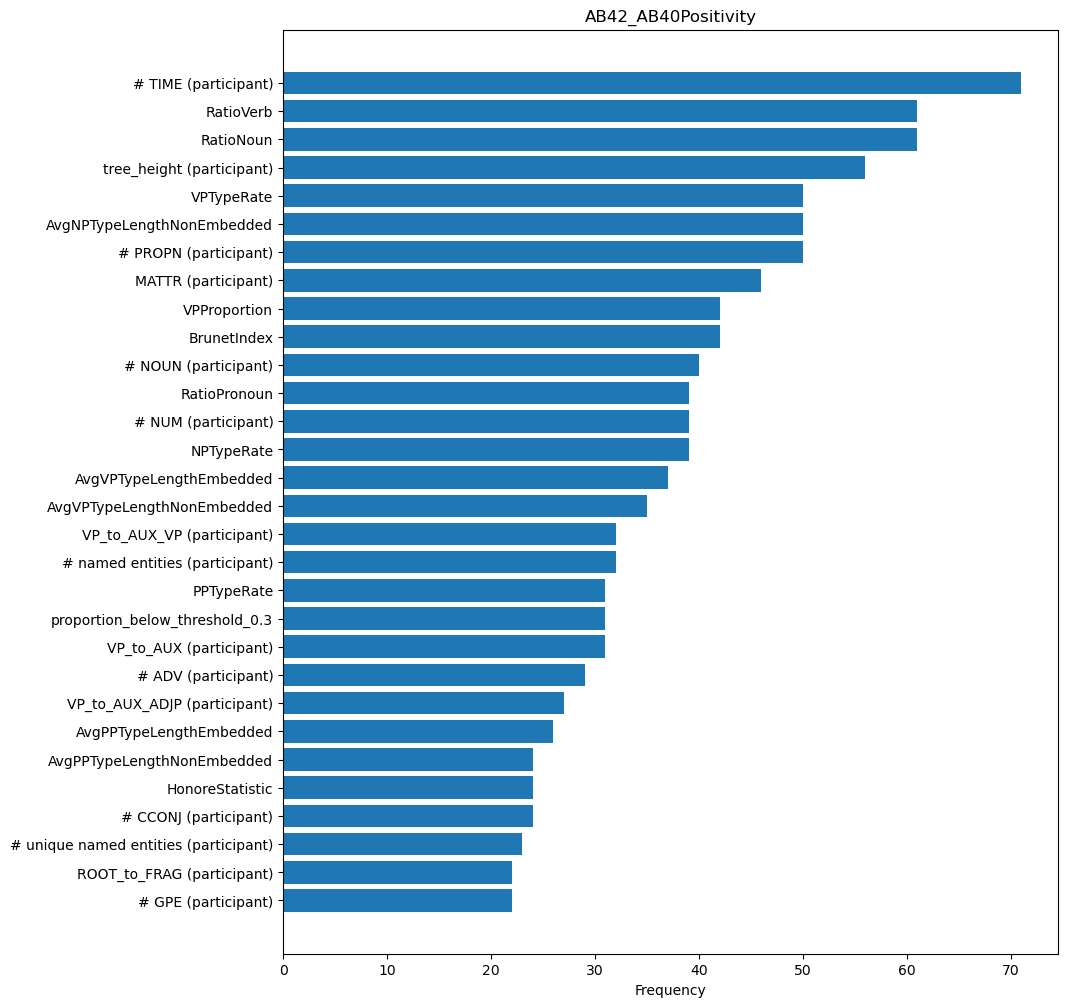

['# GPE (participant)', 'ROOT_to_FRAG (participant)', '# unique named entities (participant)', '# CCONJ (participant)', 'HonoreStatistic', 'AvgPPTypeLengthNonEmbedded', 'AvgPPTypeLengthEmbedded', 'VP_to_AUX_ADJP (participant)', '# ADV (participant)', 'VP_to_AUX (participant)', 'proportion_below_threshold_0.3', 'PPTypeRate', '# named entities (participant)', 'VP_to_AUX_VP (participant)', 'AvgVPTypeLengthNonEmbedded', 'AvgVPTypeLengthEmbedded', 'NPTypeRate', '# NUM (participant)', 'RatioPronoun', '# NOUN (participant)', 'BrunetIndex', 'VPProportion', 'MATTR (participant)', '# PROPN (participant)', 'AvgNPTypeLengthNonEmbedded', 'VPTypeRate', 'tree_height (participant)', 'RatioNoun', 'RatioVerb', '# TIME (participant)']



In [208]:
ml_analysis('MOCA_impairment', audio=False)
ml_analysis('tTau_AB42Positivity', audio=False)
ml_analysis('AB42_AB40Positivity', audio=False)

# Stat Approach

In [173]:
def get_topK(X, y, cols, score_func, runs=10, k=TOP_K):
    # Create object that will rank features based on the score function
    select = SelectKBest(score_func=score_func)
    top_ks = []
    top_scores = []
    for _ in range(runs):
        # Obtain the scores for all the features
        scores = list(select.fit(X, y).scores_)
        # Associate each score to the feature that is related to
        n_scores = list(zip(scores, [i for i in range(len(scores))]))
        # Sort the scores from highest to lowest
        n_scores.sort(key=lambda x: x[0], reverse=True)
        # Retrieve scores and features indexes
        scores, pos = zip(*n_scores)
        # Save top-k scores and their feature names
        top_scores.append(list(scores[:k]))
        top_ks.append(list(cols[list(pos)[:k]]))

    return top_ks, top_scores

## F_Cassif

In [197]:
def f_info(feat_to_predict: str, audio=True):
    PATH = os.path.join(DATA_FOLDER, FULL_DATASET_NAME if audio else NO_AUDIO_DATASET_NAME)
    # Load the dataset
    X_raw, y_raw = load_raw_data(PATH, feat_to_predict)
    # Get the column names (without the label)
    cols = X_raw.columns.to_numpy()
    X, y = X_raw.to_numpy(), y_raw.to_numpy().ravel()

    # F Function
    f_top_ks, f_top_scores = get_topK(X, y, cols, f_classif, runs=1)
    f_top_ks, f_top_scores = f_top_ks[0], f_top_scores[0]
    mapped = list(filter(lambda x: not math.isnan(x[1]), list(zip(f_top_ks, f_top_scores))))
    f_top_ks, f_top_scores = zip(*sorted(mapped, key=(lambda x: x[1]), reverse=True))
    plot_best_feat(f_top_ks, f_top_scores, title=f'F_Function Scores ({feat_to_predict} - {"Full" if audio else "No Audio"})')

### Full Data

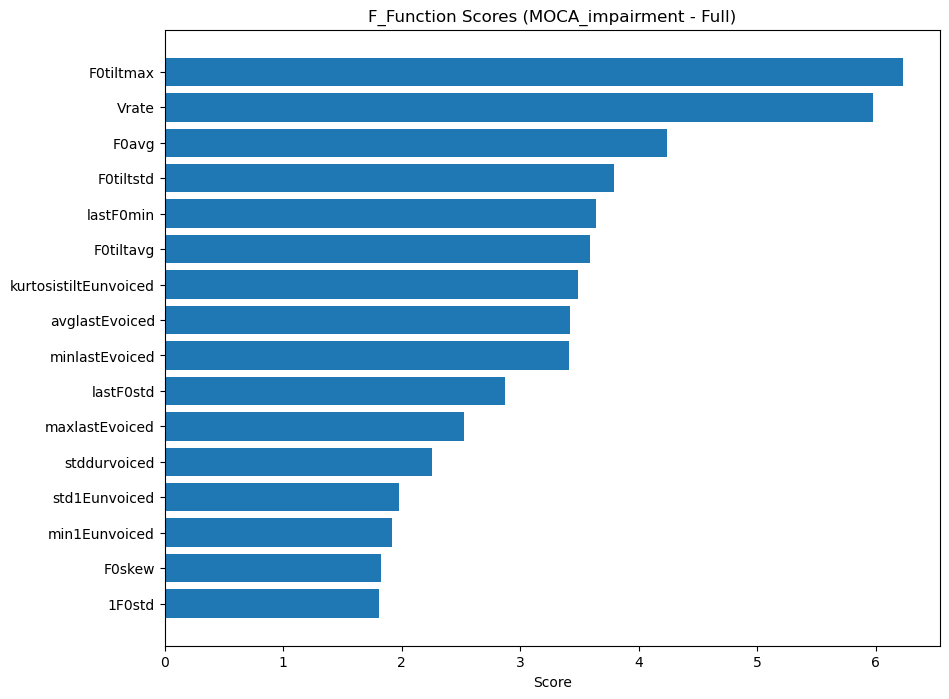

['1F0std', 'F0skew', 'min1Eunvoiced', 'std1Eunvoiced', 'stddurvoiced', 'maxlastEvoiced', 'lastF0std', 'minlastEvoiced', 'avglastEvoiced', 'kurtosistiltEunvoiced', 'F0tiltavg', 'lastF0min', 'F0tiltstd', 'F0avg', 'Vrate', 'F0tiltmax']


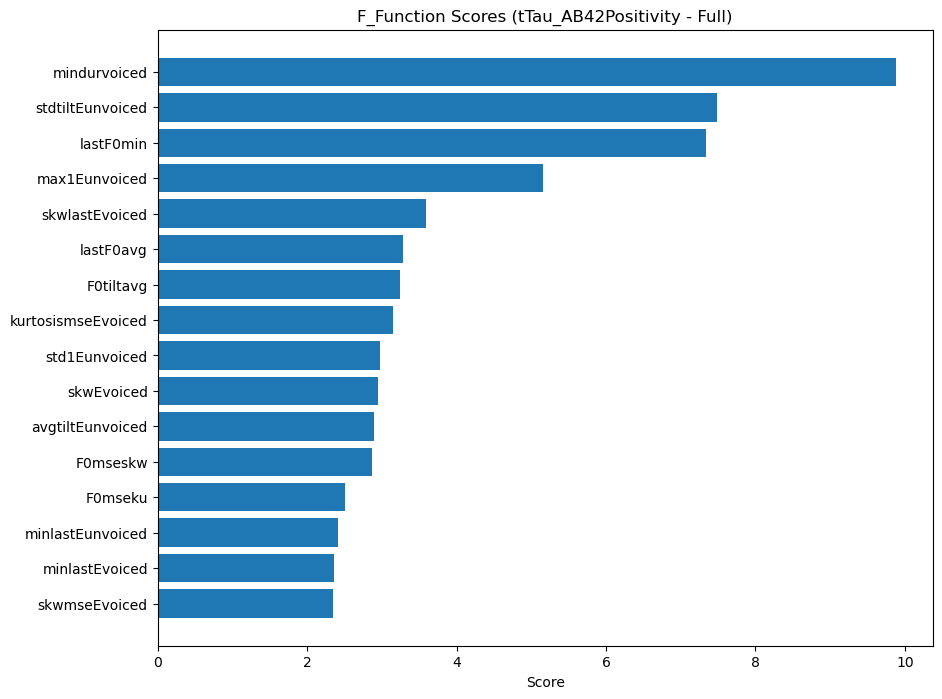

['skwmseEvoiced', 'minlastEvoiced', 'minlastEunvoiced', 'F0mseku', 'F0mseskw', 'avgtiltEunvoiced', 'skwEvoiced', 'std1Eunvoiced', 'kurtosismseEvoiced', 'F0tiltavg', 'lastF0avg', 'skwlastEvoiced', 'max1Eunvoiced', 'lastF0min', 'stdtiltEunvoiced', 'mindurvoiced']


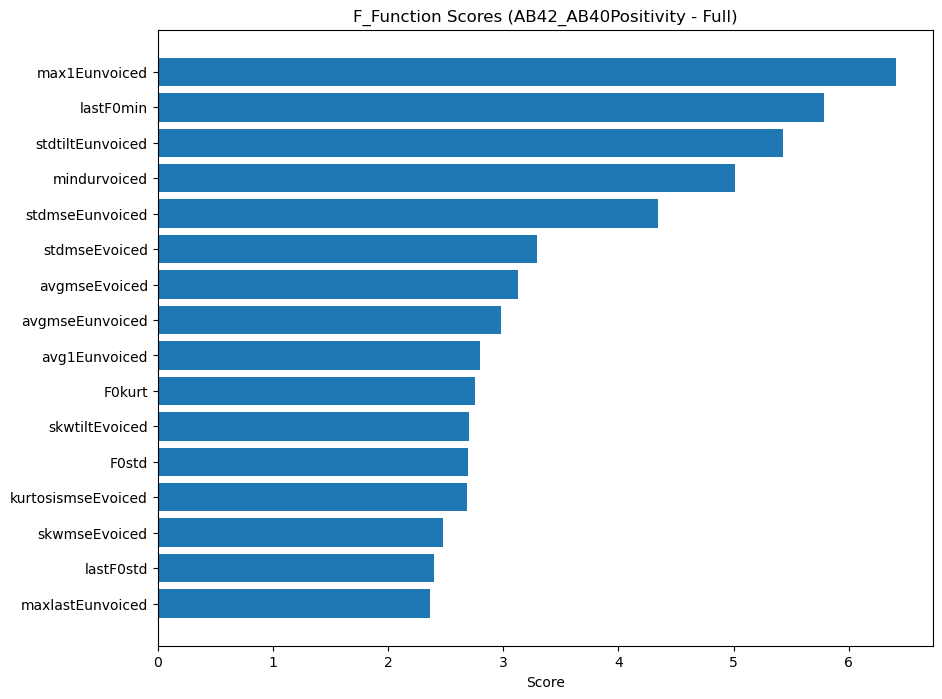

['maxlastEunvoiced', 'lastF0std', 'skwmseEvoiced', 'kurtosismseEvoiced', 'F0std', 'skwtiltEvoiced', 'F0kurt', 'avg1Eunvoiced', 'avgmseEunvoiced', 'avgmseEvoiced', 'stdmseEvoiced', 'stdmseEunvoiced', 'mindurvoiced', 'stdtiltEunvoiced', 'lastF0min', 'max1Eunvoiced']


In [209]:
f_info('MOCA_impairment')
f_info('tTau_AB42Positivity')
f_info('AB42_AB40Positivity')

### No Audio

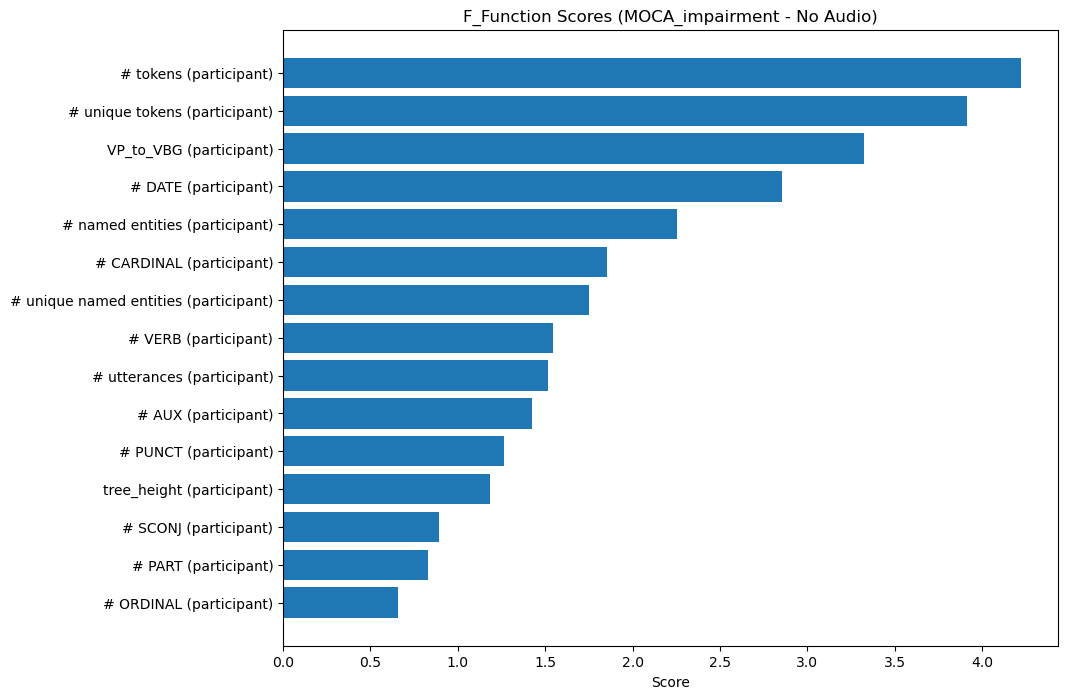

['# ORDINAL (participant)', '# PART (participant)', '# SCONJ (participant)', 'tree_height (participant)', '# PUNCT (participant)', '# AUX (participant)', '# utterances (participant)', '# VERB (participant)', '# unique named entities (participant)', '# CARDINAL (participant)', '# named entities (participant)', '# DATE (participant)', 'VP_to_VBG (participant)', '# unique tokens (participant)', '# tokens (participant)']


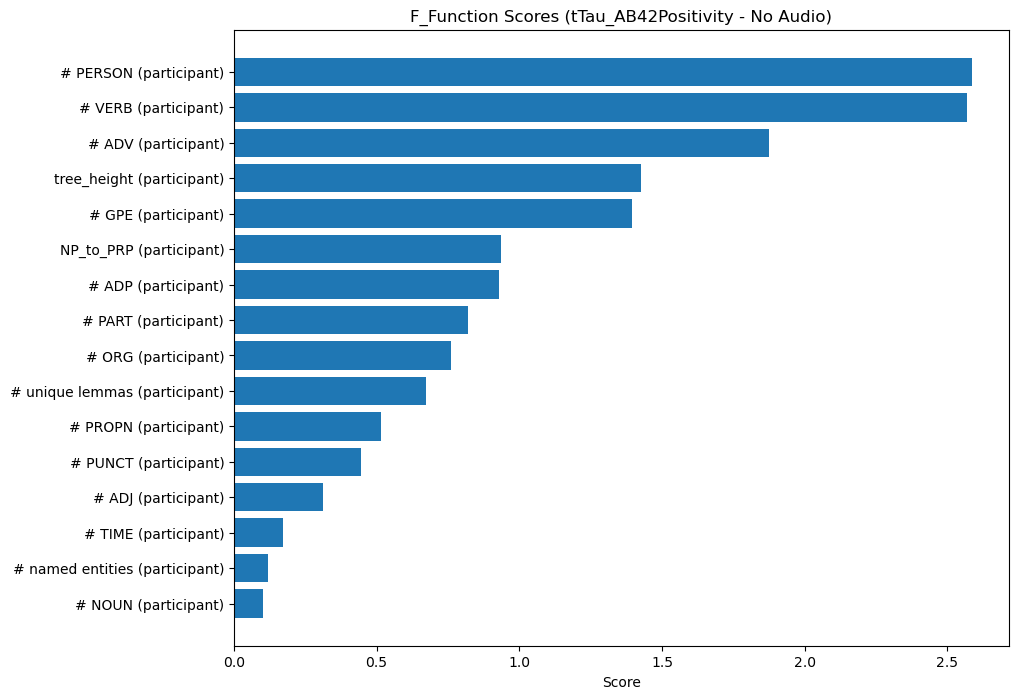

['# NOUN (participant)', '# named entities (participant)', '# TIME (participant)', '# ADJ (participant)', '# PUNCT (participant)', '# PROPN (participant)', '# unique lemmas (participant)', '# ORG (participant)', '# PART (participant)', '# ADP (participant)', 'NP_to_PRP (participant)', '# GPE (participant)', 'tree_height (participant)', '# ADV (participant)', '# VERB (participant)', '# PERSON (participant)']


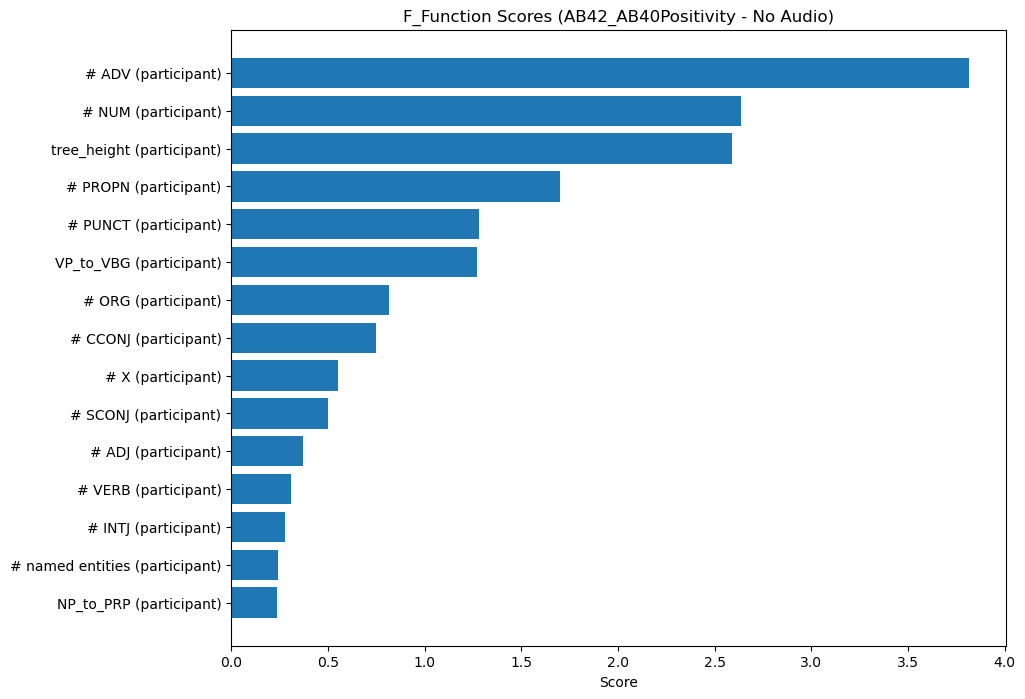

['NP_to_PRP (participant)', '# named entities (participant)', '# INTJ (participant)', '# VERB (participant)', '# ADJ (participant)', '# SCONJ (participant)', '# X (participant)', '# CCONJ (participant)', '# ORG (participant)', 'VP_to_VBG (participant)', '# PUNCT (participant)', '# PROPN (participant)', 'tree_height (participant)', '# NUM (participant)', '# ADV (participant)']


In [210]:
f_info('MOCA_impairment', audio=False)
f_info('tTau_AB42Positivity', audio=False)
f_info('AB42_AB40Positivity', audio=False)

## Mutual Information

In [215]:
def m_info(to_predict, audio=True):
    PATH = os.path.join(DATA_FOLDER, FULL_DATASET_NAME if audio else NO_AUDIO_DATASET_NAME)
    # Load the dataset
    X_raw, y_raw = load_raw_data(PATH, to_predict)
    # Get the column names (without the label)
    cols = X_raw.columns.to_list()
    X, y = X_raw.to_numpy(), y_raw.to_numpy().ravel()

    importances = mutual_info_classif(X, y)
    feat_importances = pd.Series(importances, cols)
    feat_importances = feat_importances.nlargest(30).sort_values()
    feat_importances.plot(kind='barh')
    plt.title(f'Mutual Information ({to_predict} - {"Full" if audio else "No Audio"})')
    plt.show()
    print(list(feat_importances.index))
    print()

### Full Data

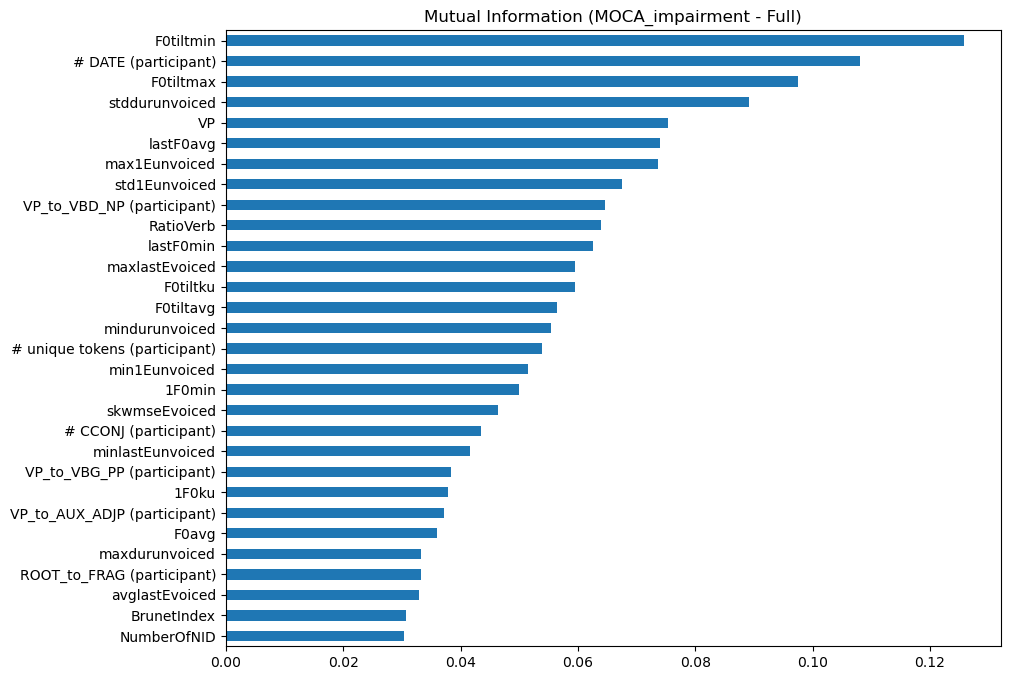

['NumberOfNID', 'BrunetIndex', 'avglastEvoiced', 'ROOT_to_FRAG (participant)', 'maxdurunvoiced', 'F0avg', 'VP_to_AUX_ADJP (participant)', '1F0ku', 'VP_to_VBG_PP (participant)', 'minlastEunvoiced', '# CCONJ (participant)', 'skwmseEvoiced', '1F0min', 'min1Eunvoiced', '# unique tokens (participant)', 'mindurunvoiced', 'F0tiltavg', 'F0tiltku', 'maxlastEvoiced', 'lastF0min', 'RatioVerb', 'VP_to_VBD_NP (participant)', 'std1Eunvoiced', 'max1Eunvoiced', 'lastF0avg', 'VP', 'stddurunvoiced', 'F0tiltmax', '# DATE (participant)', 'F0tiltmin']



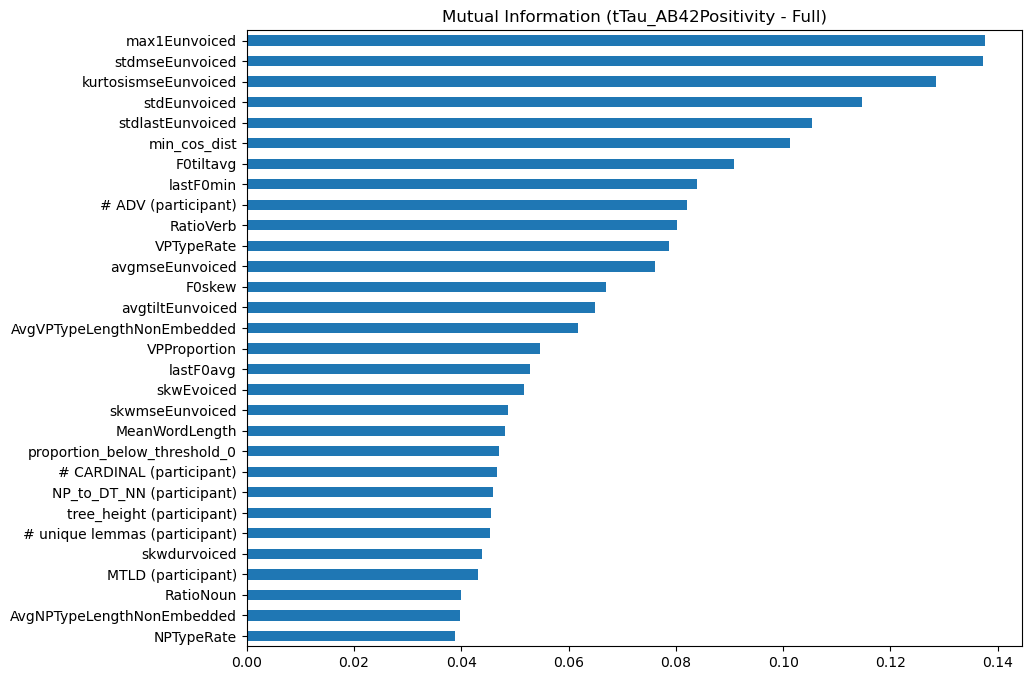

['NPTypeRate', 'AvgNPTypeLengthNonEmbedded', 'RatioNoun', 'MTLD (participant)', 'skwdurvoiced', '# unique lemmas (participant)', 'tree_height (participant)', 'NP_to_DT_NN (participant)', '# CARDINAL (participant)', 'proportion_below_threshold_0', 'MeanWordLength', 'skwmseEunvoiced', 'skwEvoiced', 'lastF0avg', 'VPProportion', 'AvgVPTypeLengthNonEmbedded', 'avgtiltEunvoiced', 'F0skew', 'avgmseEunvoiced', 'VPTypeRate', 'RatioVerb', '# ADV (participant)', 'lastF0min', 'F0tiltavg', 'min_cos_dist', 'stdlastEunvoiced', 'stdEunvoiced', 'kurtosismseEunvoiced', 'stdmseEunvoiced', 'max1Eunvoiced']



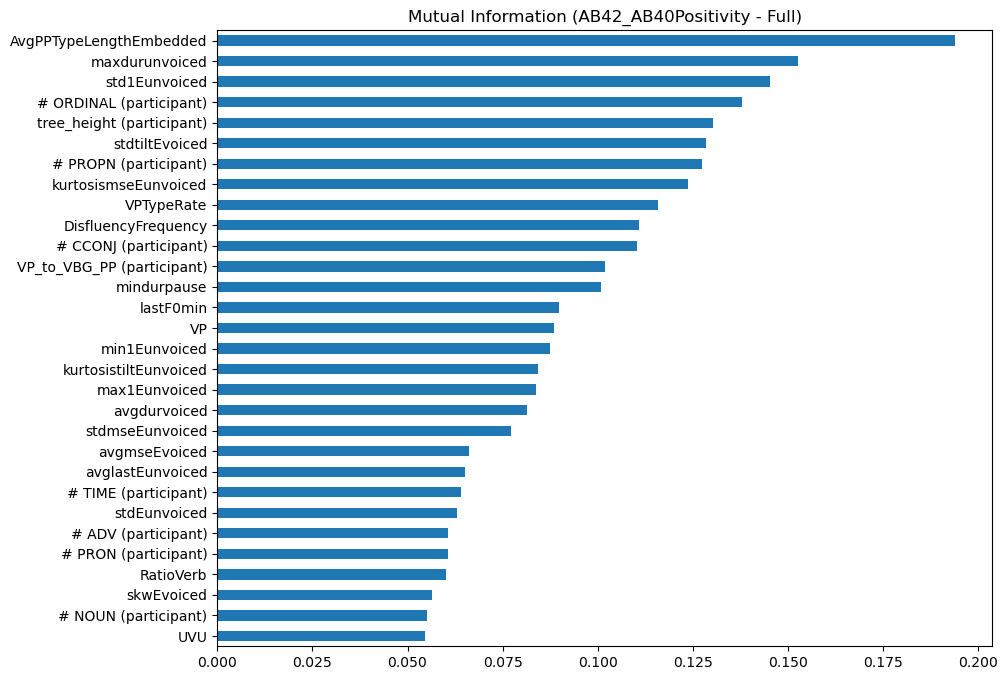

['UVU', '# NOUN (participant)', 'skwEvoiced', 'RatioVerb', '# PRON (participant)', '# ADV (participant)', 'stdEunvoiced', '# TIME (participant)', 'avglastEunvoiced', 'avgmseEvoiced', 'stdmseEunvoiced', 'avgdurvoiced', 'max1Eunvoiced', 'kurtosistiltEunvoiced', 'min1Eunvoiced', 'VP', 'lastF0min', 'mindurpause', 'VP_to_VBG_PP (participant)', '# CCONJ (participant)', 'DisfluencyFrequency', 'VPTypeRate', 'kurtosismseEunvoiced', '# PROPN (participant)', 'stdtiltEvoiced', 'tree_height (participant)', '# ORDINAL (participant)', 'std1Eunvoiced', 'maxdurunvoiced', 'AvgPPTypeLengthEmbedded']



In [216]:
m_info('MOCA_impairment')
m_info('tTau_AB42Positivity')
m_info('AB42_AB40Positivity')

### No Audio

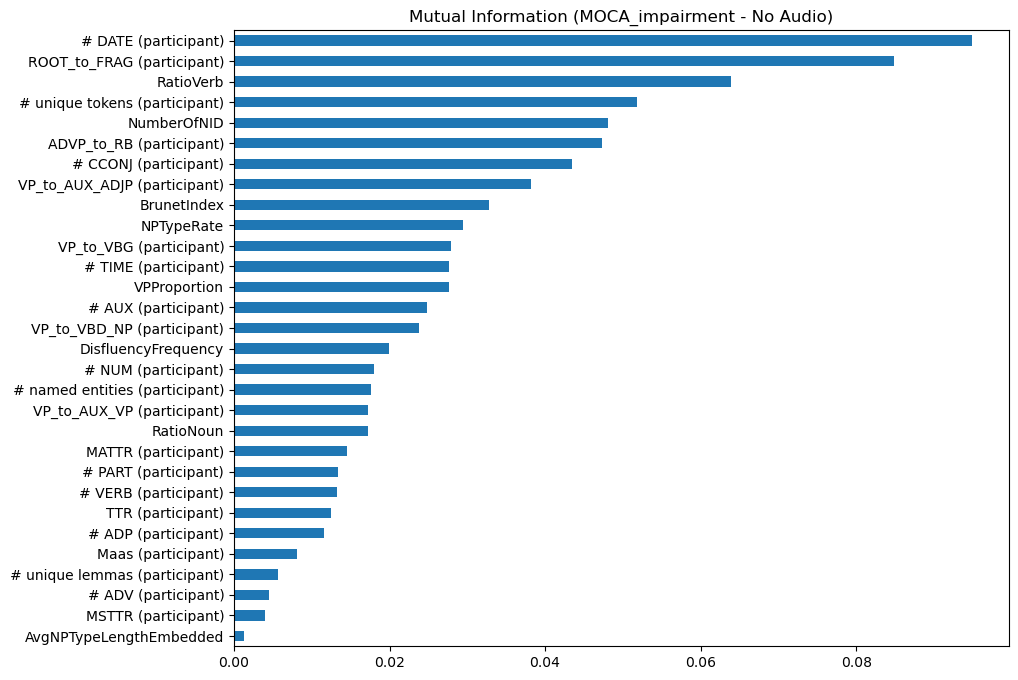

['AvgNPTypeLengthEmbedded', 'MSTTR (participant)', '# ADV (participant)', '# unique lemmas (participant)', 'Maas (participant)', '# ADP (participant)', 'TTR (participant)', '# VERB (participant)', '# PART (participant)', 'MATTR (participant)', 'RatioNoun', 'VP_to_AUX_VP (participant)', '# named entities (participant)', '# NUM (participant)', 'DisfluencyFrequency', 'VP_to_VBD_NP (participant)', '# AUX (participant)', 'VPProportion', '# TIME (participant)', 'VP_to_VBG (participant)', 'NPTypeRate', 'BrunetIndex', 'VP_to_AUX_ADJP (participant)', '# CCONJ (participant)', 'ADVP_to_RB (participant)', 'NumberOfNID', '# unique tokens (participant)', 'RatioVerb', 'ROOT_to_FRAG (participant)', '# DATE (participant)']



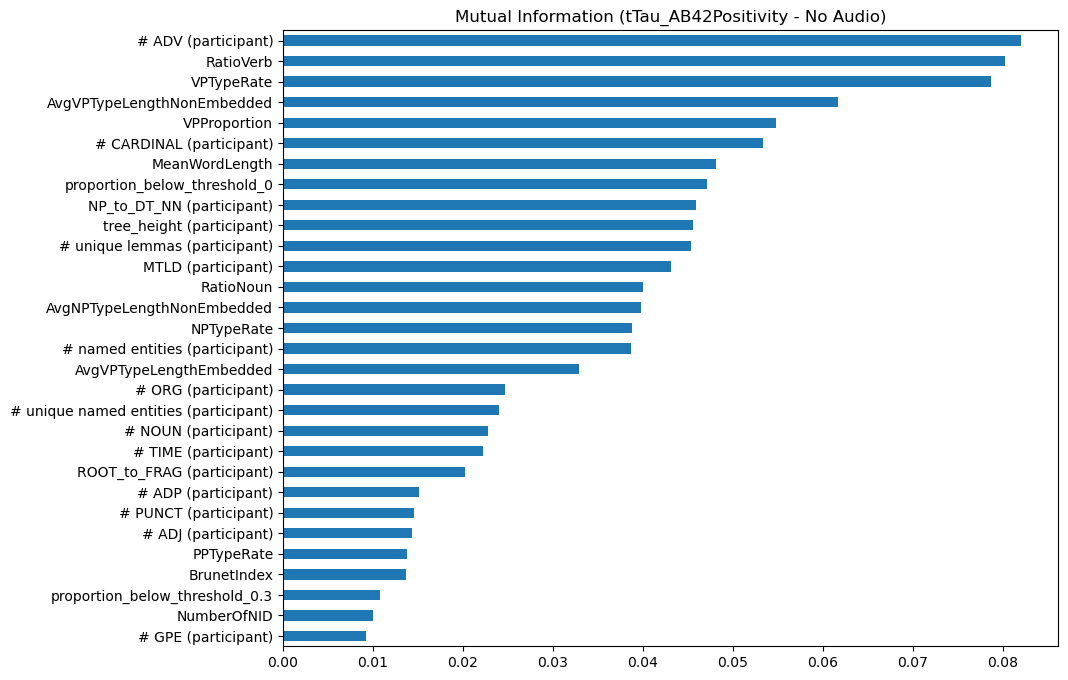

['# GPE (participant)', 'NumberOfNID', 'proportion_below_threshold_0.3', 'BrunetIndex', 'PPTypeRate', '# ADJ (participant)', '# PUNCT (participant)', '# ADP (participant)', 'ROOT_to_FRAG (participant)', '# TIME (participant)', '# NOUN (participant)', '# unique named entities (participant)', '# ORG (participant)', 'AvgVPTypeLengthEmbedded', '# named entities (participant)', 'NPTypeRate', 'AvgNPTypeLengthNonEmbedded', 'RatioNoun', 'MTLD (participant)', '# unique lemmas (participant)', 'tree_height (participant)', 'NP_to_DT_NN (participant)', 'proportion_below_threshold_0', 'MeanWordLength', '# CARDINAL (participant)', 'VPProportion', 'AvgVPTypeLengthNonEmbedded', 'VPTypeRate', 'RatioVerb', '# ADV (participant)']



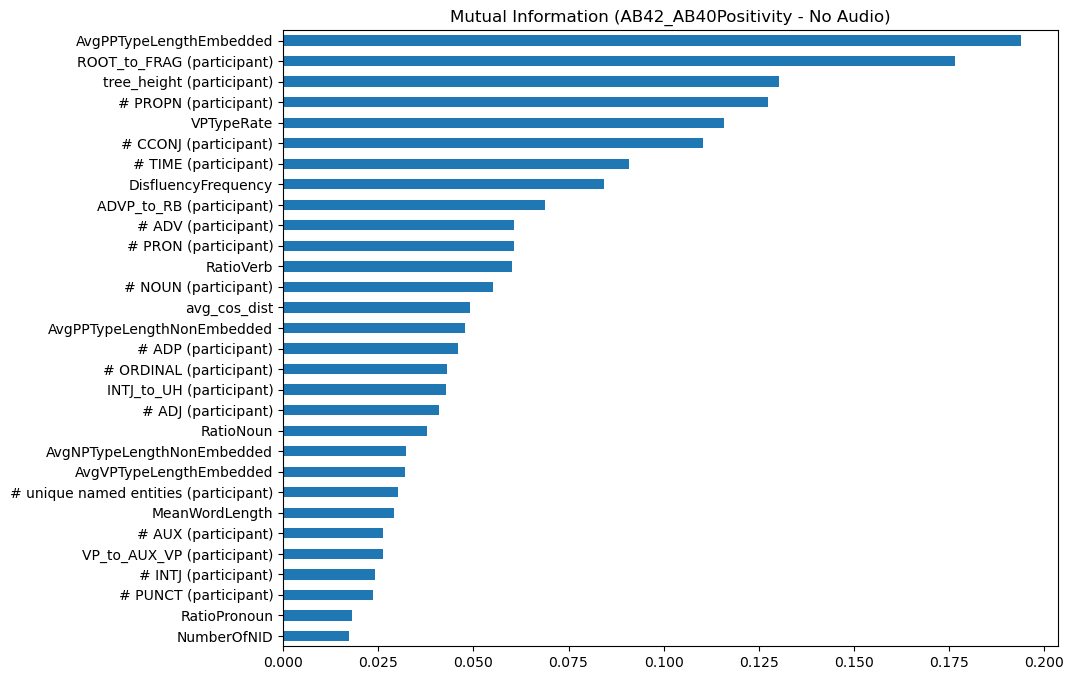

['NumberOfNID', 'RatioPronoun', '# PUNCT (participant)', '# INTJ (participant)', 'VP_to_AUX_VP (participant)', '# AUX (participant)', 'MeanWordLength', '# unique named entities (participant)', 'AvgVPTypeLengthEmbedded', 'AvgNPTypeLengthNonEmbedded', 'RatioNoun', '# ADJ (participant)', 'INTJ_to_UH (participant)', '# ORDINAL (participant)', '# ADP (participant)', 'AvgPPTypeLengthNonEmbedded', 'avg_cos_dist', '# NOUN (participant)', 'RatioVerb', '# PRON (participant)', '# ADV (participant)', 'ADVP_to_RB (participant)', 'DisfluencyFrequency', '# TIME (participant)', '# CCONJ (participant)', 'VPTypeRate', '# PROPN (participant)', 'tree_height (participant)', 'ROOT_to_FRAG (participant)', 'AvgPPTypeLengthEmbedded']



In [217]:
m_info('MOCA_impairment', audio=False)
m_info('tTau_AB42Positivity', audio=False)
m_info('AB42_AB40Positivity', audio=False)

# Forward Selection

In [120]:
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier

def forward(to_predict, dataset='full.csv'):
    # Load the dataset
    X_raw, y_raw = load_raw_data(os.path.join(DATA_FOLDER, dataset), to_predict)
    # Get the column names (without the label)
    cols = X_raw.columns
    X, y = X_raw.to_numpy(), y_raw.to_numpy().ravel()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    ffs = SequentialFeatureSelector(
        RandomForestClassifier(),
        k_features=10,
        forward=True,
        n_jobs=-1
     )

    ffs.fit(X_train, y_train)

    out = ''
    out += (str(to_predict) + '\n')
    out += f'Best scores: {ffs.k_score_}\n'
    out += (str(ffs.k_feature_names_) + '\n')
    out += (str(cols[list(ffs.k_feature_idx_)]) + '\n')
    out += ('*'*60 + '\n')

    return out, ffs

## No Audio

In [121]:
X_raw, y_raw = load_raw_data(os.path.join(DATA_FOLDER, 'no_audio.csv'), 'tTau_AB42Positivity')
NO_AUDIO_COLS = X_raw.columns

### tTau_AB42Positivity

In [ ]:
tTau_res_no_audio = []
for _ in range(100):
    print(f'Iteration {_}')
    tTau_res_no_audio.append(forward('tTau_AB42Positivity', dataset='no_audio.csv'))

In [ ]:
count = {}
for _, ffs in tTau_res_no_audio:
    for feat in list(ffs.k_feature_names_):
        if feat not in count:
            count[feat] = 0
        count[feat] += 1

tTau_feats_no_audio, tTau_freqs_no_audio = zip(*sorted(list(count.items()), key=(lambda x: x[1])))
tTau_feats_no_audio = list(NO_AUDIO_COLS[list(map(int, tTau_feats_no_audio))])
plot_best_feat(tTau_feats_no_audio[-30:], tTau_freqs_no_audio[-30:], title='Best feature frequenzy (tTau_AB42Positivity - No Audio)')

### AB42_AB40Positivity

In [ ]:
ab42_res_no_audio = []
for _ in range(100):
    print(f'Iteration {_}')
    ab42_res_no_audio.append(forward('AB42_AB40Positivity', dataset='no_audio.csv'))

In [ ]:
count = {}
for _, ffs in ab42_res_no_audio:
    for feat in list(ffs.k_feature_names_):
        if feat not in count:
            count[feat] = 0
        count[feat] += 1

ab42_feats_no_audio, ab42_freqs_no_audio = zip(*sorted(list(count.items()), key=(lambda x: x[1])))
ab42_feats_no_audio = list(NO_AUDIO_COLS[list(map(int, ab42_feats_no_audio))])
plot_best_feat(ab42_feats_no_audio[-30:], ab42_freqs_no_audio[-30:], title='Best feature frequenzy (AB42_AB40Positivity - No Audio)')

### MOCA_impairment

In [ ]:
moca_res_no_audio = []
for _ in range(100):
    print(f'Iteration {_}')
    moca_res_no_audio.append(forward('MOCA_impairment', dataset='no_audio.csv'))

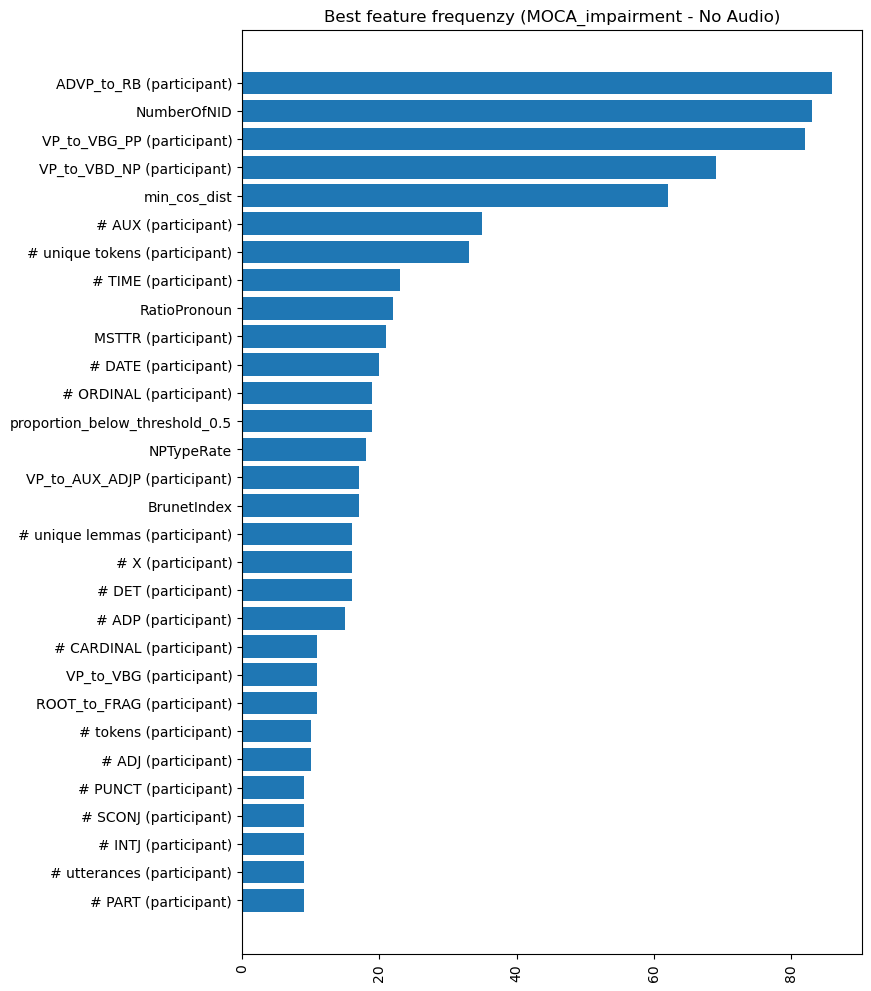

In [129]:
count = {}
for _, ffs in moca_res_no_audio:
    for feat in list(ffs.k_feature_names_):
        if feat not in count:
            count[feat] = 0
        count[feat] += 1

moca_feats_no_audio, moca_freqs_no_audio = zip(*sorted(list(count.items()), key=(lambda x: x[1])))
moca_feats_no_audio = list(NO_AUDIO_COLS[list(map(int, moca_feats_no_audio))])
plot_best_feat(moca_feats_no_audio[-30:], moca_freqs_no_audio[-30:], title='Best feature frequenzy (MOCA_impairment - No Audio)')

## Full

In [130]:
X_raw, y_raw = load_raw_data(os.path.join(DATA_FOLDER, 'full.csv'), 'tTau_AB42Positivity')
COLS = X_raw.columns

### tTau_AB42Positivity

In [ ]:
tTau_res = []
for _ in range(100):
    print(f'Iteration {_}')
    tTau_res.append(forward('tTau_AB42Positivity', dataset='full.csv'))

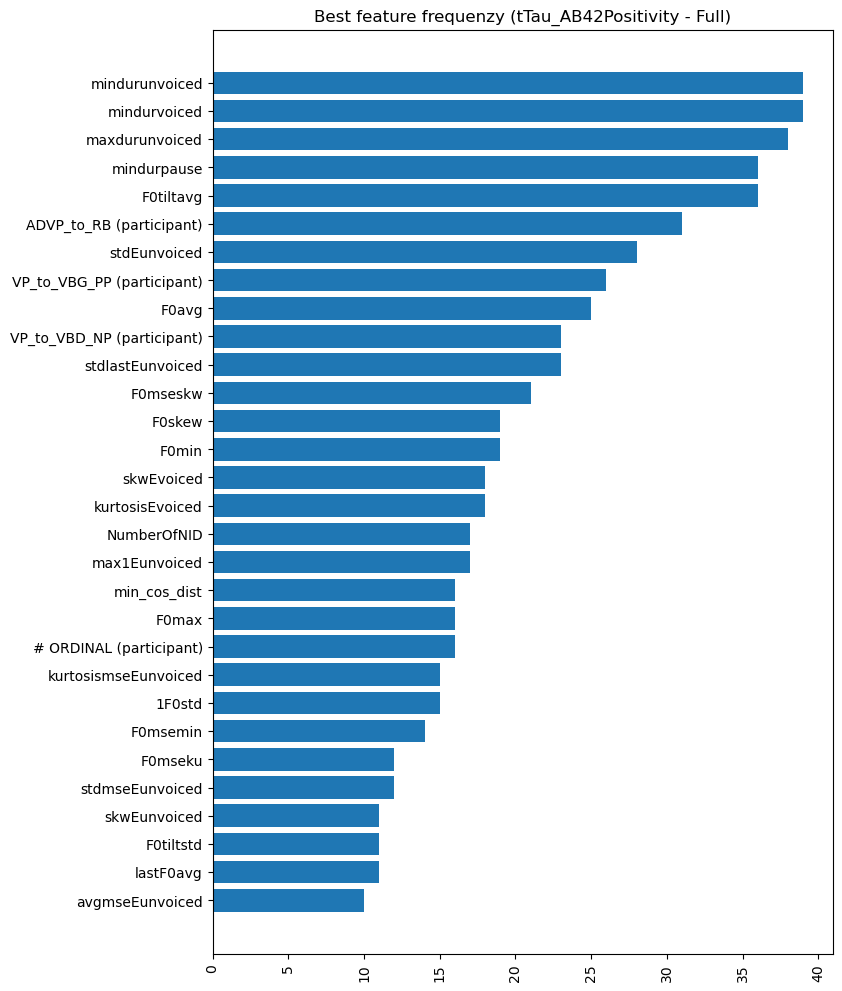

In [132]:
count = {}
for _, ffs in tTau_res:
    for feat in list(ffs.k_feature_names_):
        if feat not in count:
            count[feat] = 0
        count[feat] += 1

tTau_feats, tTau_freqs = zip(*sorted(list(count.items()), key=(lambda x: x[1])))
tTau_feats = list(COLS[list(map(int, tTau_feats))])
plot_best_feat(tTau_feats[-30:], tTau_freqs[-30:], title='Best feature frequenzy (tTau_AB42Positivity - Full)')

### AB42_AB40Positivity

In [ ]:
ab42_res = []
for _ in range(100):
    print(f'Iteration {_}')
    ab42_res.append(forward('AB42_AB40Positivity', dataset='full.csv'))

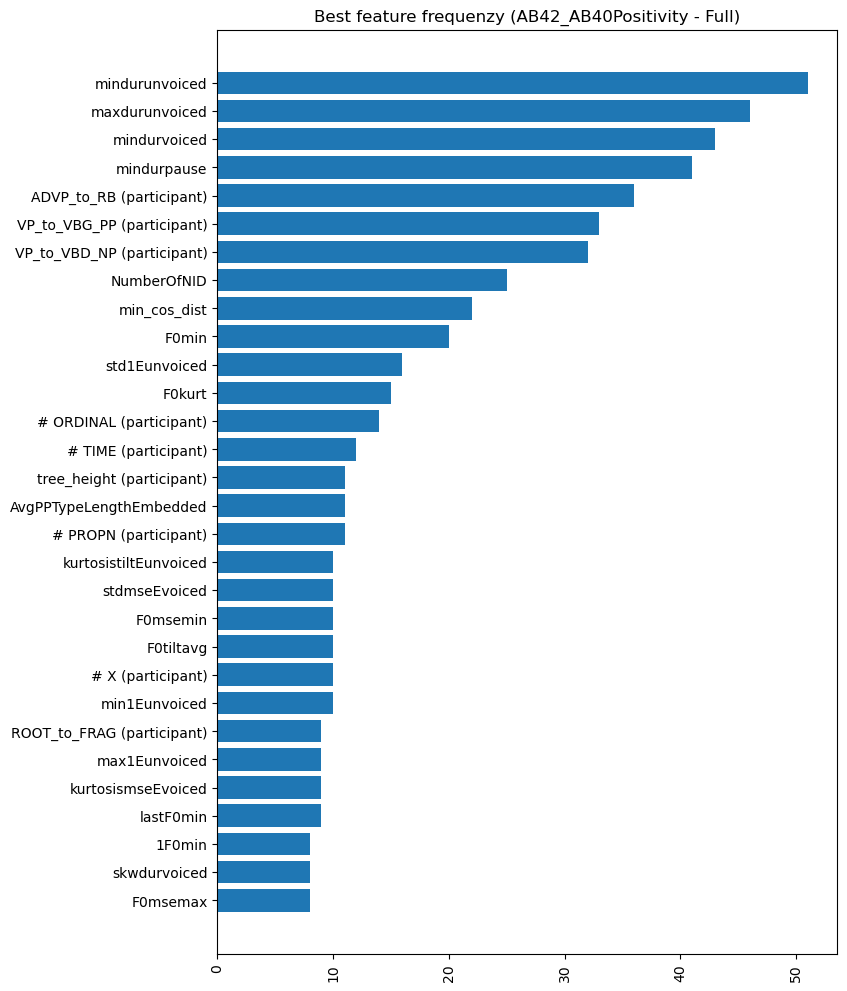

In [134]:
count = {}
for _, ffs in ab42_res:
    for feat in list(ffs.k_feature_names_):
        if feat not in count:
            count[feat] = 0
        count[feat] += 1

ab42_feats, ab42_freqs = zip(*sorted(list(count.items()), key=(lambda x: x[1])))
ab42_feats = list(COLS[list(map(int, ab42_feats))])
plot_best_feat(ab42_feats[-30:], ab42_freqs[-30:], title='Best feature frequenzy (AB42_AB40Positivity - Full)')

### MOCA_impairment

In [ ]:
moca_res = []
for _ in range(100):
    print(f'Iteration {_}')
    moca_res.append(forward('MOCA_impairment', dataset='full.csv'))

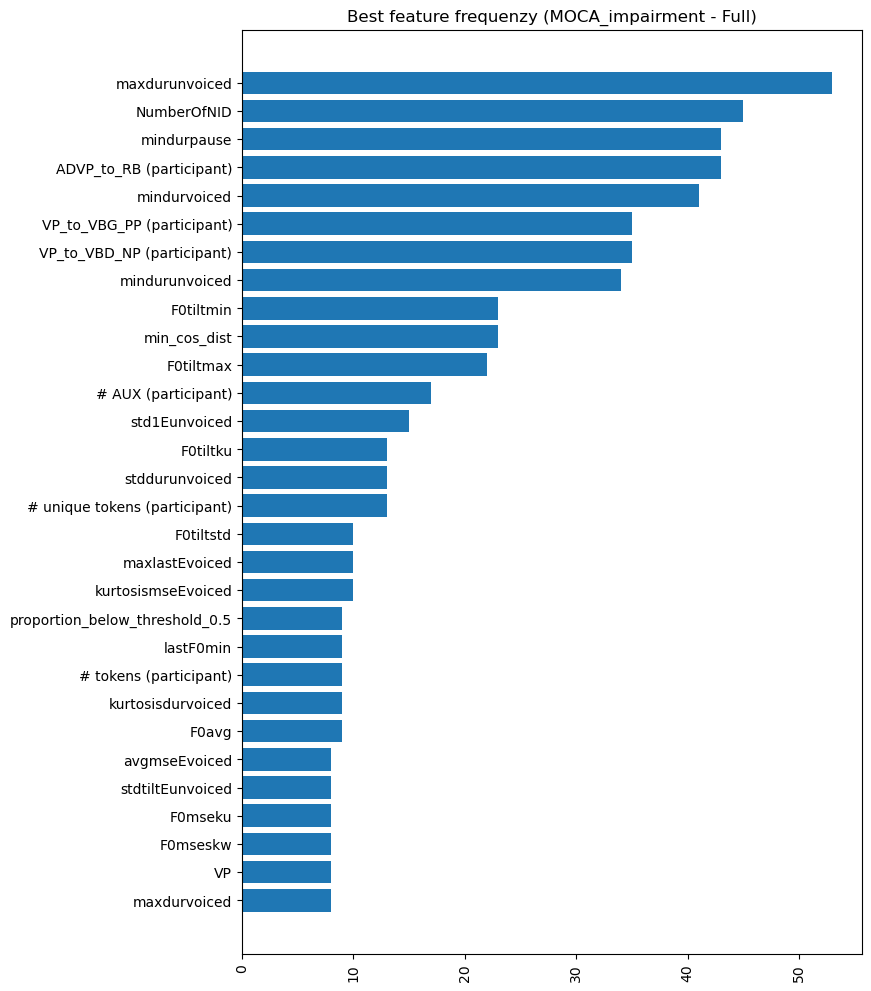

In [136]:
count = {}
for _, ffs in moca_res:
    for feat in list(ffs.k_feature_names_):
        if feat not in count:
            count[feat] = 0
        count[feat] += 1

moca_feats, moca_freqs = zip(*sorted(list(count.items()), key=(lambda x: x[1])))
moca_feats = list(COLS[list(map(int, moca_feats))])
plot_best_feat(moca_feats[-30:], moca_freqs[-30:], title='Best feature frequenzy (MOCA_impairment - Full)')

# Focus on tTau_AB42Positivity

After reviewing of all the obtained data, we've found that tTau_AB42Positivity is our best target when using the features obtained from the tree-based ML approach.</br>

Thus, we now perform again our analysis using the average results of 10k runs, in order to obtain more stable final results.

In [8]:
def ldata(selected_feats, feat_to_predict: str):
    # Load the entire csv file
    data = pd.read_csv('data/no_audio_corrected.csv')

    # Join labels and data so that truth values are aligned with original data
    lbls = LABELS[['id', feat_to_predict]]
    temp = data.merge(lbls, on='id', how='left')
    temp = temp.dropna()
    # Extract only the ground truths
    labels = pd.DataFrame(temp[feat_to_predict], columns=[feat_to_predict])
    data = temp.drop(feat_to_predict, axis=1)
    data = data.set_index('id')
    # Keep just the selected features
    data = data[selected_feats]
    data = pd.DataFrame(StandardScaler().fit_transform(data), columns=data.columns, index=data.index)
    data.columns = list(map(lambda x: x.replace(' (participant)', ''), data.columns.to_list()))

    return data, labels

In [54]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np
from tqdm import tqdm

def ml(selected_feats, feat_to_predict, n_estimators, runs):
    X, y = ldata(selected_feats, feat_to_predict)

    results = []
    for _ in tqdm(range(runs)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
        X_train, y_train = SMOTE.fit_resample(X_train, y_train)
        
        model = RandomForestClassifier(n_estimators = n_estimators)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        results.append((
            accuracy_score(y_test, y_pred),
            f1_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred)
        ))

    accs, f1s, precs, recs = zip(*results)
    print(f'Accuracy:    {np.mean(accs)} +- {np.std(accs)}')
    print(f'F1:          {np.mean(f1s)} +- {np.std(f1s)}')
    print(f'Precision:   {np.mean(precs)} +- {np.std(precs)}')
    print(f'Recall:      {np.mean(recs)} +- {np.std(recs)}')

In [38]:
features = ['BrunetIndex', 'MATTR (participant)', 'tree_height (participant)',
       'VP_to_AUX_VP (participant)', 'RatioNoun', 'RatioVerb',
       '# TIME (participant)', 'VPProportion']
ml(features, 'tTau_AB42Positivity', n_estimators=200, runs=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [38:16<00:00,  4.36it/s]

Accuracy:    0.8324846153846156 +- 0.08972418980791295
F1:          0.42212198412698415 +- 0.3040146536639682
Precision:   0.44637404761904764 +- 0.36135398467786917
Recall:      0.4502 +- 0.3371497590092569


# Explainability

Our analysis yielded good results, but in order to strengthen our confidence in our work we need to explain our results.</br>
In particular, we are going to use the SHAP values in order to understand how the top features influence our predictions.

In [3]:
np.random.seed(42)

TARGET = 'tTau_AB42Positivity'
CV_REPETITIONS = 1000
SEEDS = np.random.random_integers(100000, size=CV_REPETITIONS)
N_ESTIMATORS = 200

FEATURES = ['BrunetIndex', 'MATTR (participant)', 'tree_height (participant)',
       'VP_to_AUX_VP (participant)', 'RatioNoun', 'RatioVerb',
       '# TIME (participant)', 'VPProportion']

In [4]:
def load_exp(selected_feats):
    # Load the entire csv file
    data = pd.read_csv('data/no_audio_corrected.csv')

    # Join labels and data so that truth values are aligned with original data
    lbls = LABELS[['id', TARGET]]
    temp = data.merge(lbls, on='id', how='left')
    temp = temp.dropna()
    # Extract only the ground truths
    labels = temp[['id', TARGET]].set_index('id').astype(int)
    data = temp.drop(TARGET, axis=1)
    data = data.set_index('id')
    # Keep just the selected features
    data = data[selected_feats]
    data = pd.DataFrame(StandardScaler().fit_transform(data), columns=data.columns, index=data.index)
    data.columns = list(map(lambda x: x.replace(' (participant)', ''), data.columns.to_list()))
    data[TARGET] = labels
    return data.reset_index()

df = load_exp(FEATURES)

X = df.drop(['id', TARGET], axis=1)
y = df[TARGET]
ids = df['id']

In [5]:
# Use a dict to track the SHAP values of each observation per CV repitition
# And given that we have 2 classes, we can save the SHAP values for both classes separately
shap_values_per_cv_0 = dict()
shap_values_per_cv_1 = dict()

for sample in X.index:
    # Create keys for each sample
    shap_values_per_cv_0[sample] = {}
    shap_values_per_cv_1[sample] = {}
    # Then, keys for each CV fold within each sample
    for CV_repeat in range(CV_REPETITIONS):
        shap_values_per_cv_0[sample][CV_repeat] = {}
        shap_values_per_cv_1[sample][CV_repeat] = {}

In [6]:
from sklearn.model_selection import StratifiedKFold

# Split the data into folds
def get_split(X: pd.DataFrame, y: pd.DataFrame, seed:int):
    CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    idx_train, idx_test = [], []
    # Loop through each fold and append the training & test indices to the empty lists above
    for fold in CV.split(X, y):
        idx_train.append(fold[0]), idx_test.append(fold[1])
    
    return idx_train, idx_test

In [14]:
def full_cv_run(idx, idx_train, idx_test, seed, shap_values_per_cv):
    # Loop through each outer fold and extract SHAP values 
    for outer_idx_train, outer_idx_test in zip(idx_train, idx_test):
        X_train, X_test = X.iloc[outer_idx_train, :], X.iloc[outer_idx_test, :]
        y_train = y.iloc[outer_idx_train]

        model = RandomForestClassifier(n_estimators=N_ESTIMATORS, random_state=seed)
        model.fit(X_train, y_train)

        # Use SHAP to explain predictions
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)

        # Extract SHAP information per fold per sample 
        for i, test_index in enumerate(outer_idx_test):
            shap_values_per_cv[0][test_index][idx] = shap_values[0][i]
            shap_values_per_cv[1][test_index][idx] = shap_values[1][i]

In [15]:
from tqdm import tqdm

# Compute all the SHAP values
for idx in tqdm(range(CV_REPETITIONS)):
    idx_train, idx_test = get_split(X, y, SEEDS[idx])
    full_cv_run(idx, idx_train, idx_test, SEEDS[idx], (shap_values_per_cv_0, shap_values_per_cv_1))

100%|██████████| 1000/1000 [20:51<00:00,  1.25s/it]


In [16]:
# Compute average Shap values, their Stdevs, and their min/max

def get_stats(shap_values_per_cv):
    average_shap_values, stds, ranges = [],[],[]
    for i in range(0,len(df)):
        df_per_obs = pd.DataFrame.from_dict(shap_values_per_cv[i]) # Get all SHAP values for sample number i
        # Get relevant statistics for every sample 
        average_shap_values.append(df_per_obs.mean(axis=1).values) 
        stds.append(df_per_obs.std(axis=1).values)
        ranges.append(df_per_obs.max(axis=1).values-df_per_obs.min(axis=1).values)

    return average_shap_values, stds, ranges

average_shap_values_0, stds_0, ranges_0 = get_stats(shap_values_per_cv_0)
average_shap_values_1, stds_1, ranges_1 = get_stats(shap_values_per_cv_1)

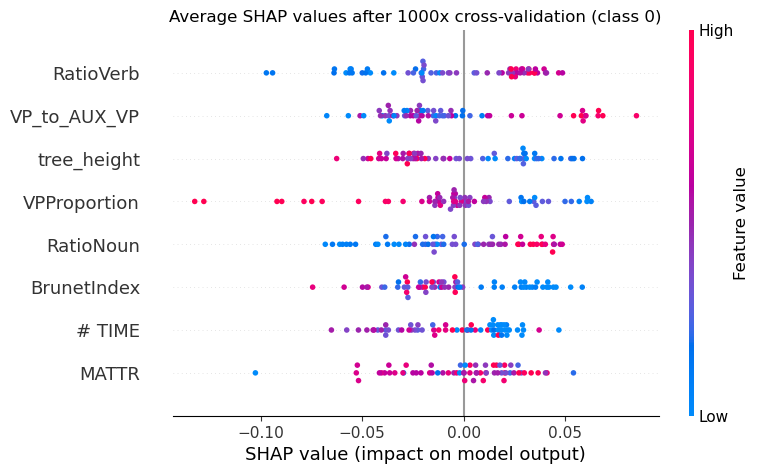

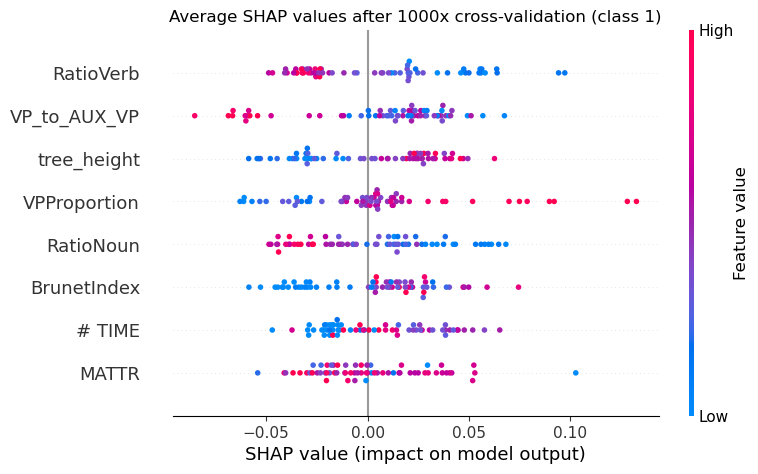

In [17]:
def plot_shap_vals(average_values, label: int):
    shap.summary_plot(np.array(average_values), X, show = False)
    plt.title(f'Average SHAP values after {CV_REPETITIONS}x cross-validation (class {label})')
    plt.show()

plot_shap_vals(average_shap_values_0, 0)
plot_shap_vals(average_shap_values_1, 1)

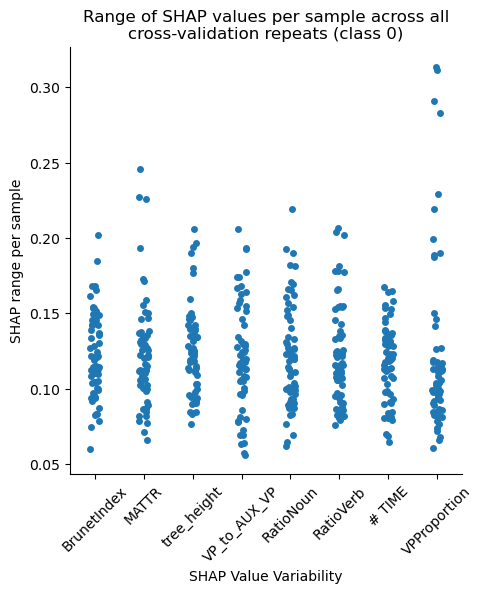

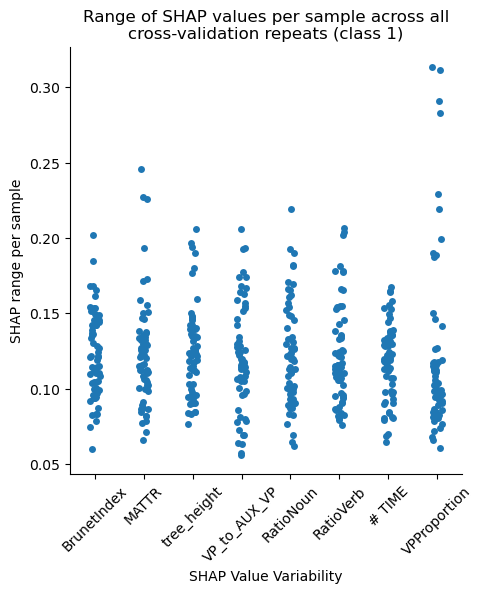

In [18]:
import seaborn as sns

ranges_0 = pd.DataFrame(ranges_0)
ranges_0.columns = X.columns

ranges_1 = pd.DataFrame(ranges_1)
ranges_1.columns = X.columns

def plot_ranges(ranges: pd.DataFrame, label: int):
    # Transpose dataframe to long form
    values, labels = [],[]
    for i in range(len(ranges.columns)):
        for j in range(len(ranges)):
            values.append(ranges.T[j][i])
            labels.append(ranges.columns[i])
    long_df = pd.DataFrame([values,labels]).T
    long_df.columns = ['Values', 'Features']


    title = f'Range of SHAP values per sample across all\ncross-validation repeats (class {label})'
    xlab, ylab = 'SHAP Value Variability', 'SHAP range per sample'
    sns.catplot(data = long_df, x = 'Features', y = 'Values').set(xlabel = xlab, ylabel = ylab,
                                                                                title = title)
    plt.xticks(rotation=45)
    plt.show()

# Plot SHAP ranges per feature
plot_ranges(ranges_0, 0)
plot_ranges(ranges_1, 1)